In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
df=pd.read_csv('merged2_data.csv')
df

,Date,Close,Currently
0,2014-09-17,457.334015,0.09
1,2014-09-18,424.440002,0.09
2,2014-09-19,394.795990,0.09
3,2014-09-20,408.903992,0.09
4,2014-09-21,398.821014,0.09
...,...,...,...
3158,2023-05-11,27000.789063,5.08
3159,2023-05-12,26804.990234,5.08
3160,2023-05-13,26784.078125,5.08
3161,2023-05-14,26930.638672,5.08


In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dense, concatenate

# Veri setini oluşturma ve ölçeklendirme
selected_columns = ['Close', 'Currently']
data = df[selected_columns].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Kayan pencere boyutu ve özellik sayısı
window_size = 10
num_features = 2  # Close ve Currently özellikleri için

# Kayan pencere veri setini oluşturma
X = []
y = []
for i in range(len(scaled_data) - window_size):
    window = scaled_data[i:i+window_size]
    X.append(window)
    y.append(scaled_data[i+window_size][0])  # Sadece Close özelliğini hedef alıyoruz

X = np.array(X)
y = np.array(y)

# Veri setini train ve test olarak ayırma
train_size = int(0.8 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

# LSTM modelini oluşturma
close_input = Input(shape=(window_size, num_features))
lstm_close = LSTM(units=64)(close_input)

currently_input = Input(shape=(window_size, num_features))
lstm_currently = LSTM(units=64)(currently_input)

concatenated = concatenate([lstm_close, lstm_currently])

dense = Dense(units=32, activation='relu')(concatenated)
output = Dense(units=1)(dense)

model = Model(inputs=[close_input, currently_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 2)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 2)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 64)           17152       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 64)           17152       ['input_2[0][0]']                
                                                                                              

In [4]:
model = Sequential()
model.add(LSTM(units=64, input_shape=(window_size, X_train.shape[2])))
model.add(Dense(units=1))


In [5]:
model.compile(loss='mean_squared_error', optimizer='adam')


In [6]:
num_epochs = 10
batch_size = 64

history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))


Epoch 1/10
40/40 [==============================] - 1s 13ms/step - loss: 0.0096 - val_loss: 0.0012
Epoch 2/10
40/40 [==============================] - 0s 5ms/step - loss: 5.3265e-04 - val_loss: 0.0013
Epoch 3/10
40/40 [==============================] - 0s 5ms/step - loss: 4.4958e-04 - val_loss: 0.0012
Epoch 4/10
40/40 [==============================] - 0s 5ms/step - loss: 4.0741e-04 - val_loss: 0.0021
Epoch 5/10
40/40 [==============================] - 0s 5ms/step - loss: 4.0542e-04 - val_loss: 0.0013
Epoch 6/10
40/40 [==============================] - 0s 5ms/step - loss: 3.8859e-04 - val_loss: 0.0013
Epoch 7/10
40/40 [==============================] - 0s 5ms/step - loss: 3.7646e-04 - val_loss: 0.0012
Epoch 8/10
40/40 [==============================] - 0s 5ms/step - loss: 3.8523e-04 - val_loss: 0.0012
Epoch 9/10
40/40 [==============================] - 0s 5ms/step - loss: 3.6313e-04 - val_loss: 0.0012
Epoch 10/10
40/40 [==============================] - 0s 5ms/step - loss: 3.5405e-04 -

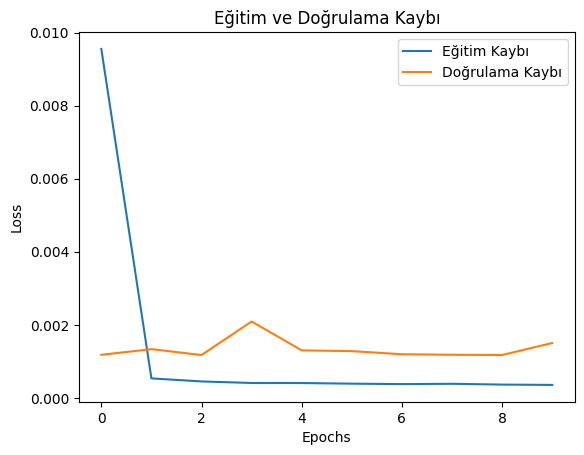

In [7]:
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [8]:
X_test_reshaped = X_test.reshape(X_test.shape[0], window_size, X_test.shape[2])


In [9]:
y_test_pred = model.predict(X_test_reshaped)


20/20 [==============================] - 0s 1ms/step


In [10]:
# Tahmin değerlerini yeniden şekillendirme
y_test_pred_reshaped = np.zeros((len(y_test_pred), 2))
y_test_pred_reshaped[:, 0] = y_test_pred.flatten()  # 1. sütuna tahmin değerlerini yerleştirme

# Geri dönüşüm işlemi
y_test_pred_denorm = scaler.inverse_transform(y_test_pred_reshaped)

# y_test verilerini yeniden şekillendirme
y_test_reshaped = np.zeros((len(y_test), 2))
y_test_reshaped[:, 0] = y_test.flatten()  # 1. sütuna gerçek değerleri yerleştirme

# Geri dönüşüm işlemi
y_test_denorm = scaler.inverse_transform(y_test_reshaped)


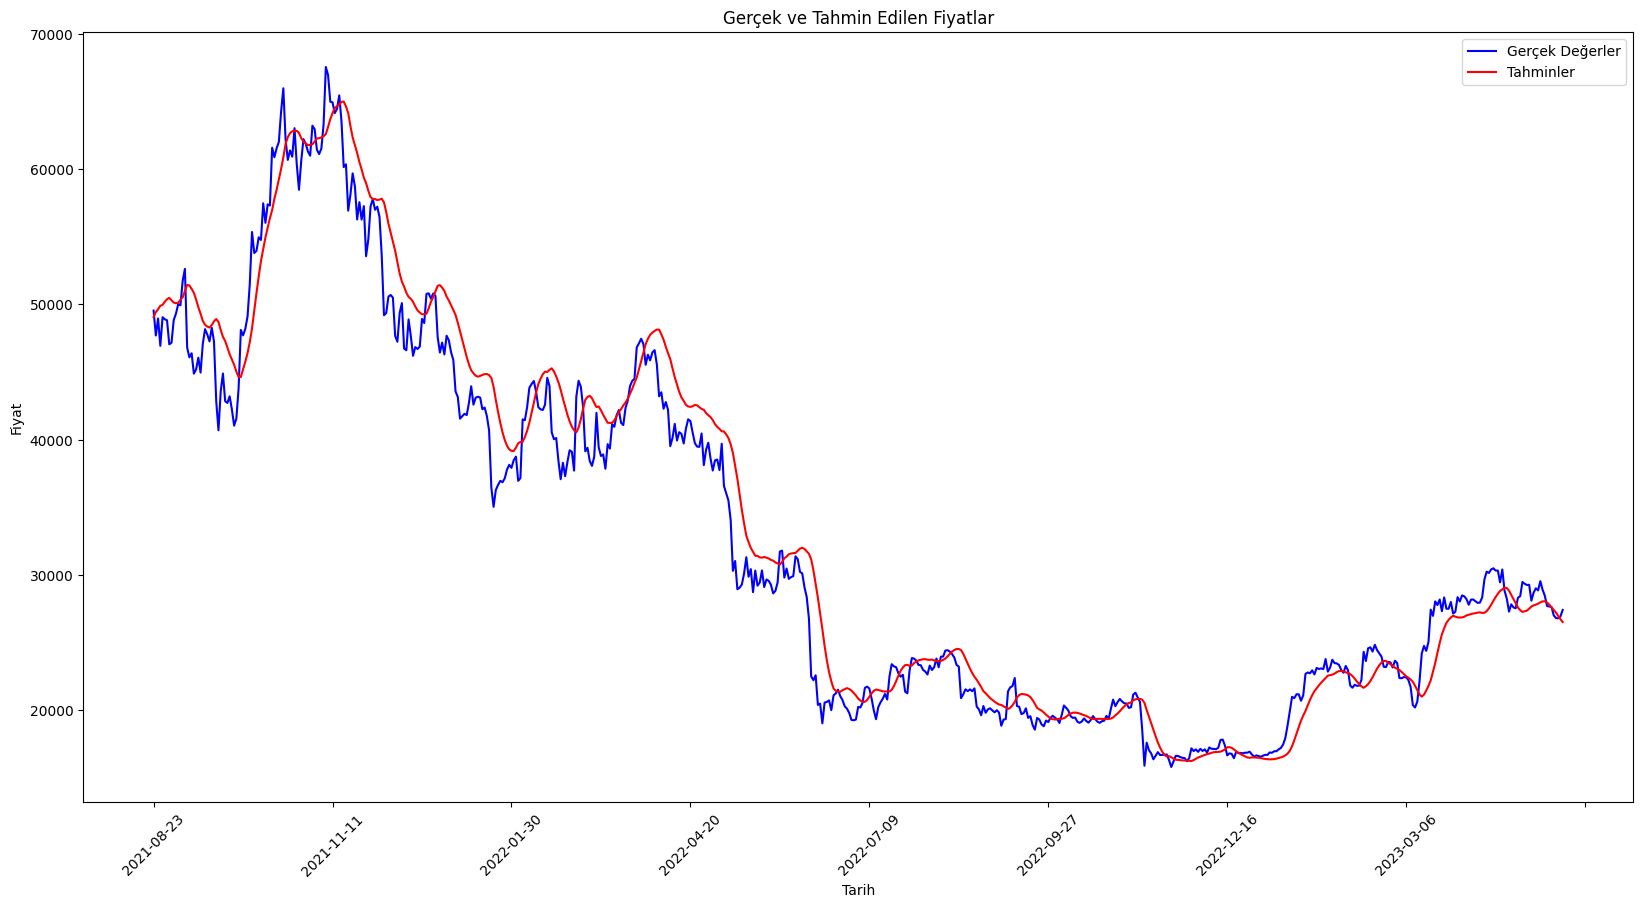

In [11]:
import matplotlib.pyplot as plt

# Son 631 tarihleri alın
dates = df['Date'].values[-631:]

# İndeksler
indices = range(len(y_test_pred_denorm))

# Grafiğin boyutunu ayarla
plt.figure(figsize=(20, 10))

# Gerçek değerlerin grafiğini çizdirme
plt.plot(dates, y_test_denorm[:, 0], color='blue', label='Gerçek Değerler')

# Tahmin edilen değerlerin grafiğini çizdirme
plt.plot(dates, y_test_pred_denorm[:, 0], color='red', label='Tahminler')

# Eksen etiketleri
plt.xlabel('Tarih')
plt.ylabel('Fiyat')

# Başlık
plt.title('Gerçek ve Tahmin Edilen Fiyatlar')

# X ekseni etiketlerini 45 derece döndürme
plt.xticks(rotation=45)

# Tarih etiketlerini sıkıştır
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))

# Legent (Açıklama)
plt.legend()

# Grafiği gösterme
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# MSE hesaplama
MSE = mean_squared_error(y_test_denorm, y_test_pred_denorm)
print("Mean Squared Error (MSE):", mse1)

# RMSE hesaplama
RMSE = np.sqrt(mse1)
print("Root Mean Squared Error (RMSE):", rmse1)

# MAE hesaplama
MAE = mean_absolute_error(y_test_denorm, y_test_pred_denorm)
print("Mean Absolute Error (MAE):", mae1)

# R2 skoru hesaplama
R2 = r2_score(y_test_denorm, y_test_pred_denorm)
print("R2 Score:", r21)


Mean Squared Error (MSE): 3408735.3579969513
Root Mean Squared Error (RMSE): 1846.2760784879792
Mean Absolute Error (MAE): 947.7322889751993
R2 Score: 0.9815100329583402


In [16]:
import pandas as pd

# Değerleri bir sözlük yapısında sakla
results = {'MSE': [MSE], 'RMSE': [RMSE], 'MAE': [MAE], 'R2': [R2]}

# DataFrame oluştur ve index değerlerini varsayılan değerlerle ata
LSTM_ERROR4 = pd.DataFrame.from_dict(results, orient='index').T

# Çıktıyı metin dosyasına aktar
output_text = LSTM_ERROR4.to_string(index=False)

# Metin dosyasını kaydet
with open('LSTM_ERROR4.txt', 'w') as file:
    file.write(output_text)
